In [1]:
from dataclasses import dataclass

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(3698)

In [2]:
@dataclass()
class UOT:
    C: np.ndarray
    a: np.ndarray
    b: np.ndarray
    tau: float

@dataclass()
class EntRegUOT(UOT):
    eta: float

In [3]:
def norm_inf(x):
    return np.amax(np.abs(x))

def calc_entropy(P):
    return -np.sum(P * np.log(P) - P)

def calc_KL(P, Q):
    return np.sum(P * np.log(P / Q) - P + Q)

def calc_f(p, X):
    return (p.C * X).sum() \
        + p.tau * calc_KL(X.sum(-1), p.a) \
        + p.tau * calc_KL(X.sum(0), p.b)

In [4]:
def exact_uot(p):
    n = p.C.shape[0]
    X = cp.Variable((n, n), nonneg=True)

    row_sums = cp.sum(X, axis=1)
    col_sums = cp.sum(X, axis=0)

    obj = cp.sum(cp.multiply(X, C))

    obj -= p.tau * cp.sum(cp.entr(row_sums))
    obj -= p.tau * cp.sum(cp.entr(col_sums))

    obj -= p.tau * cp.sum(cp.multiply(row_sums, cp.log(p.a)))
    obj -= p.tau * cp.sum(cp.multiply(col_sums, cp.log(p.b)))

    obj -= 2 * p.tau * cp.sum(X)
    obj += p.tau * cp.sum(p.a + p.b)

    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()

    return prob.value, X.value

In [31]:
def calc_R(p: EntRegUOT) -> float:
    n = p.C.shape[0]
    R = max(norm_inf(np.log(p.a)), norm_inf(np.log(p.b))) + max(np.log(n), norm_inf(p.C) / p.eta - np.log(n))
    return R

def calc_U(p: UOT, eps: float) -> float:
    n = p.C.shape[0]
    S = 0.5 * (alpha + beta) + 0.5 + 0.25 / np.log(n)
    T = 0.5 * (alpha + beta) * (np.log(0.5 * (alpha + beta)) + 2 * np.log(n) - 1) + np.log(n) + 2.5
    U = max(S + T, 2 * eps, 4 * eps * np.log(n) / p.tau, 4 * eps * (alpha + beta) * np.log(n) / p.tau)
    return U

def calc_k_stop(p: EntRegUOT, eps: float) -> int:
    R = calc_R(p)
    U = calc_U(p, eps)
    k_float = (p.tau * U / eps + 1) * (np.log(8 * p.eta * R) + np.log(p.tau * (p.tau + 1)) + 3 * np.log(U / eps))
    return int(k_float)

def calc_B(p: EntRegUOT, 
           u: np.ndarray,
           v: np.ndarray) -> np.ndarray:
    return np.exp((u[:, np.newaxis] + v[np.newaxis, :] - p.C) / p.eta)
    

def sinkhorn_entreg_uot(p: EntRegUOT, 
                        eps: float) -> np.ndarray:
    log = {'u': [], 'v': []}

    # Find problem dimension
    n = p.C.shape[0]

    # Initialize
    u = np.zeros(n)
    v = np.zeros(n)

    # Find stopping condition
    k_stop = calc_k_stop(p, eps)
    log['k_stop'] = k_stop

    # Loop
    scale = p.eta * p.tau / (p.eta + p.tau)
    for k in range(k_stop + 1):
        X = calc_B(p, u, v)

        # Update
        if k % 2 == 0:
            ak = X.sum(-1)
            u = (u / p.eta + np.log(p.a / ak)) * scale
        else:
            bk = X.sum(0)
            v = (v / p.eta + np.log(p.b / bk)) * scale

        log['u'].append(u)
        log['v'].append(v)
    
    return calc_B(p, u, v), log

## Experiments

### Synthetic data

#### Configuration

In [6]:
# Dimension
n = 10

# Regularization
tau = 5.0

# Mass normalization
alpha = 2.0
beta = 4.0

# Number of eps
neps = 20


#### Generation

In [47]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=50.0, size=(n, n)).astype(np.float128)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 1.0, size=n).astype(np.float128)
b = np.random.uniform(0.1, 1.0, size=n).astype(np.float128)

a = a / a.sum() * alpha
b = b / b.sum() * beta

#### Scenarios

##### Different accuracy epsilon

In [48]:
# Original UOT problem
uot_p = UOT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_uot(uot_p)

print('Optimal:', f_optimal)

Optimal: 20.904673681190204


In [65]:
# Epsilons
eps_arr = np.linspace(start=1, stop=0.05, num=neps).astype(np.float128)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    # Entropic regularization parameter
    U = calc_U(uot_p, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    p = EntRegUOT(C, a, b, tau, eta)

    # Sinkhorn
    _, log = sinkhorn_entreg_uot(p, eps)

    # Find kf
    kf = log['k_stop']

    # Find kc
    f_approx = np.array([
        calc_f(p, calc_B(p, u, v)) 
        for u, v in zip(log['u'], log['v'])
    ])
    kc = np.where(f_approx - f_optimal > eps)[0][-1]

    kfs[i] = kf
    kcs[i] = kc + 2

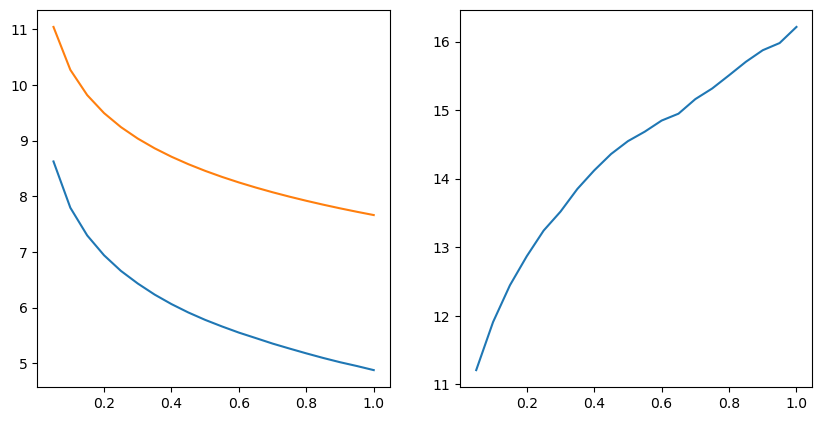

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax[0].plot(eps_arr, np.log(kcs), label='\log k_f')
ax[0].plot(eps_arr, np.log(kfs), label='\log k_c')

ax[1].plot(eps_arr, kfs / kcs, label='\log k_f')